In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
#Decomment lines 4 and 5 if you have 'x" number of void readings per minute.
#Adjust denominator as appropriate for number of readings/min.

#copyrat = copyrat.groupby(copyrat.index// 'x').mean()

# use averages from above IF PER MINUTE USED

# make list of samples:
#ratnm = copyrat.columns[1:7].tolist() # this is making a list of samples
# if the sample list is larger than 6, "1:7" will need to be increased.


In [111]:
import pandas as pd
import numpy as np

svt = 0.1; # small void threshold
#smt = 0.05; # solid material threshold not used for rats
td = 0.01; # threshold of dection for rats. in mouse data: can evaluate decrease from minute 1-3 to 8-11

In [112]:
# GOOD VERSION:

import os
import csv
import re

# Load data
rat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rat_raw_data.csv')
copyrat = rat.copy() #protect orig data
copyrat = copyrat.dropna()

## NB!!!!!!!!!!!! Adjust denominator 'x' as in next line for number of readings/min.
#copyrat = copyrat.groupby(copyrat.index// 'x').mean()
## use this above IF PER MINUTE USED


# Make a list of samples (this can be 1:7 if using 6 cages at a time. More is possible if your set up is different)
ratnm = copyrat.columns[1:7].tolist()

# Initialize a dictionary to store the averages and results for each sample
sample_data = {}

# Process each sample
for i, sample in enumerate(ratnm, start=1):
    # Calculate results for the sample
    copyrat[f'results.x{i}'] = copyrat[sample] - copyrat[sample].shift(1, fill_value=0)
    copyrat.loc[copyrat[f'results.x{i}'] < 0, f'results.x{i}'] = 0

    # Calculate column I
    copyrat[f'I.x{i}'] = copyrat[f'results.x{i}'] - copyrat[f'results.x{i}'].shift(2, fill_value=0)
    copyrat.loc[copyrat[f'results.x{i}'] > td, f'I.x{i}'] = "M"
    copyrat.loc[copyrat[f'results.x{i}'] <= td, f'I.x{i}'] = "na"

    # Calculate column K
    copyrat.loc[copyrat[f'I.x{i}'] == "M", f'K.x{i}'] = copyrat[f'results.x{i}']

    # Remove the first 15 or 30 minutes of data
    copyrat = copyrat.loc[30:, :]

    # Store the results, I, and K columns for the sample in the dictionary
    sample_data[sample] = {
        'results': copyrat[f'results.x{i}'],
        'I': copyrat[f'I.x{i}'],
        'K': copyrat[f'K.x{i}']
    }

copyrat.head()



,time,ra.x1,ra.x2,ra.x3,ra.x4,ra.x5,ra.x6,results.x1,I.x1,K.x1,...,K.x3,results.x4,I.x4,K.x4,results.x5,I.x5,K.x5,results.x6,I.x6,K.x6
30,31.0,0.42,2.41,1.83,1.22,1.17,0.78,0.0,na,NaN,...,1.83,1.22,M,1.22,1.17,M,1.17,0.78,M,0.78
31,32.0,0.42,2.41,1.83,1.21,1.17,0.78,0.0,na,NaN,...,NaN,0.00,na,NaN,0.00,na,NaN,0.00,na,NaN
32,33.0,0.41,2.40,1.82,1.21,1.17,0.78,0.0,na,NaN,...,NaN,0.00,na,NaN,0.00,na,NaN,0.00,na,NaN
33,34.0,0.41,2.40,1.82,1.21,1.17,0.78,0.0,na,NaN,...,NaN,0.00,na,NaN,0.00,na,NaN,0.00,na,NaN
34,35.0,0.41,2.40,1.81,1.20,1.16,0.77,0.0,na,NaN,...,NaN,0.00,na,NaN,0.00,na,NaN,0.00,na,NaN


In [113]:
## IF required, Rename one or more columns in the DataFrame. This will depend on the csv entirely
#copyrat = copyrat.rename(columns={'Latest: Time (min)':'time.min'})
#copyrat = copyrat.rename(columns={'Latest: 44.sham.N4 (g)':'44.sham.N4'})
#copyrat = copyrat.rename(columns={'Latest: 44.obst.N5 (g)':'44.obst.N5'})


In [135]:
# this should be working but is not.

output = [['rat id', '# of voids', 'Mean M volume', 'Max M volume', 'Total M volumes', '# of small voids', 'Residual volumes', 'Bladder capacity', 'Mean Micturition Fraction', 'Maximum Micturition Fraction']]

for sample, data in sample_data.items():

    small_voids = ((data['K'] > td) & (data['K']<=svt)).sum()
    volumes = data['K']
    num_voids = (data['K'] > td).sum()
    row = [sample, num_voids, np.mean(volumes), np.max(volumes), np.sum(volumes), small_voids, residual_data, BladderCap, MeanMF, MaxMF]
    output.append(row)

output_df = pd.DataFrame(output[1:], columns=output[0])
print('M = micturition')
print(output_df)

M = micturition
  rat id  # of voids  Mean M volume  Max M volume  Total M volumes  \
0  ra.x1          28       0.192143          0.86             5.38   
1  ra.x2           6       0.566667          2.41             3.40   
2  ra.x3          18       0.267222          1.83             4.81   
3  ra.x4          34       0.157353          1.22             5.35   
4  ra.x5           4       0.472500          1.17             1.89   
5  ra.x6          23       0.390000          1.35             8.97   

   # of small voids  
0                14  
1                 4  
2                 8  
3                23  
4                 2  
5                 9  


### have a look at voids and volumes to look at distribution in samples.

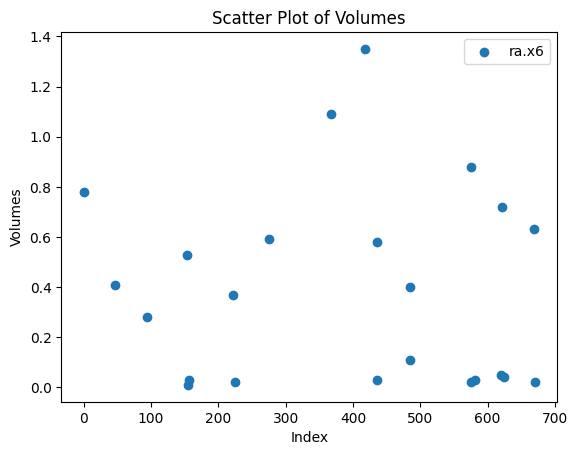

In [142]:
# num_voids
# volumes
import matplotlib.pyplot as plt
# Create histogram
scatterplots = {}
x = range(len(volumes))
plt.scatter(x, volumes, label=sample)
plt.xlabel('Index')
plt.ylabel('Volumes')
plt.title('Scatter Plot of Volumes')
plt.legend()

# Store the scatter plot for the sample
scatterplots[sample] = plt


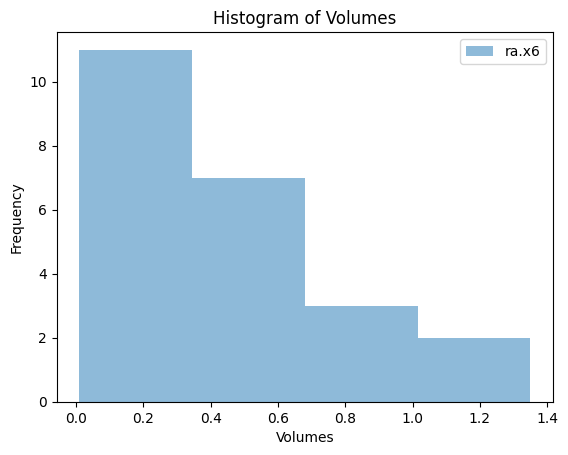

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Create histogram

plt.hist(volumes, bins=4, alpha=0.5, label=sample)
plt.xlabel('Volumes')
plt.ylabel('Frequency')
plt.title('Histogram of Volumes')
plt.legend()

        # Store the histogram for the sample
histograms[sample] = plt

In [155]:
#upload residual volume data if known for each animal
residual_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/residual_data.csv')



In [160]:
# final calculations using residual data:
calcs_df = output_df.copy()
calcs_df = pd.concat([calcs_df, residual_data], axis=1)

# make empty columns to use for calculations:
calcs_df["Bladder capacity"]= calcs_df["residual_vol"] + calcs_df["Max M volume"]
calcs_df["Mean Micturition Fraction"]= calcs_df["Mean M volume"]/calcs_df["Bladder capacity"]
calcs_df["Maximum Micturition Fraction"]= calcs_df["Max M volume"]/calcs_df["Bladder capacity"]

calcs_df.to_csv('/content/drive/MyDrive/Colab Notebooks/calcs_df.csv', index=False)

calcs_df

,rat id,# of voids,Mean M volume,Max M volume,Total M volumes,# of small voids,rat id #,residual_vol,Bladder capacity,Mean Micturition Fraction,Maximum Micturition Fraction
0,ra.x1,28,0.192143,0.86,5.38,14,ra.x1,1.0,1.86,0.103303,0.462366
1,ra.x2,6,0.566667,2.41,3.40,4,ra.x2,0.5,2.91,0.194731,0.828179
2,ra.x3,18,0.267222,1.83,4.81,8,ra.x3,5.0,6.83,0.039125,0.267936
3,ra.x4,34,0.157353,1.22,5.35,23,ra.x4,4.0,5.22,0.030144,0.233716
4,ra.x5,4,0.472500,1.17,1.89,2,ra.x5,0.8,1.97,0.239848,0.593909
5,ra.x6,23,0.390000,1.35,8.97,9,ra.x6,0.9,2.25,0.173333,0.600000
